# Evaluate artifacts in publication dates

Investigate whether MM-DD of publication is uniformly distributed.

> One issue that [we've found](https://github.com/greenelab/scihub/issues/8#issuecomment-296703994) when working with Crossref-derived publication dates is that many articles with a missing day-of-publication are coded as being published on the 1st of the month. Similarly, many articles with missing month-of-publication are coded as being published on January 1st. Therefore, articles Crossref marks as published on January 1 likely just indicate the article was published anytime that year. Articles marked as being published on the first of the month likely just indicate the article was published anytime that month. 


In [1]:
import pandas
import utils

## Read raw data

In [2]:
preprint_df = pandas.read_csv('data/01.preprints.tsv', sep='\t')
preprint_df.head(2)

,rxivist_preprint_id,preprint_date,preprint_doi,journal_date,journal_doi
0,386,2018-05-21,10.1101/327015,NaN,NaN
1,387,2018-08-03,10.1101/384123,2018-11-19,10.1128/aac.01646-18


In [3]:
access_df = pandas.read_csv(
    'data/02.unpaywall-access.tsv.xz',
    sep='\t',
    #nrows=100_000,
)
access_df = access_df.query("crossref_type in @utils.get_crossref_types()")
access_df['month_day'] = access_df.journal_date.str.slice(start=5)
access_df.head(2)

,doi,crossref_type,journal_date,unpaywall_access,journal_access,journal_access_evidence,journal_access_license,journal_fully_oa,month_day
0,10.1080/21645515.2017.1330236,journal-article,2017-06-12,1,0,NaN,NaN,0,06-12
3,10.1088/0004-6256/135/4/1201,journal-article,2008-03-04,1,1,open (via free pdf),NaN,0,03-04


## Compute month-day counts

In [4]:
def get_month_day_counts(series):
    """
    Take a series of YYYY-MM-DD formatted strings and return
    a dataframe of MM-DD counts.
    """
    month_day_count_df = (
        series
        .dropna()
        .pipe(lambda x: x[x.map(len) == 10])  # Remove strings that are not full dates
        .str.slice(start=5)
        .value_counts()
        .reset_index()
    )
    month_day_count_df.columns = ['month_day', 'count']
    month_day_count_df = month_day_count_df.sort_values('month_day')
    month_day_count_df['enrichment'] = month_day_count_df['count'] / (month_day_count_df['count'].sum() / 365)
    return month_day_count_df

In [5]:
month_day_count_df = pandas.concat([
    get_month_day_counts(preprint_df.preprint_date).assign(resource='biorxiv_preprint_date'),
    get_month_day_counts(preprint_df.journal_date).assign(resource='biorxiv_journal_date'),
    get_month_day_counts(access_df.journal_date).assign(resource='crossref'),
]).sort_values(['month_day', 'resource'])

In [6]:
month_day_count_df.head(10)

,month_day,count,enrichment,resource
207,01-01,41,0.947332,biorxiv_journal_date
362,01-01,25,0.242377,biorxiv_preprint_date
0,01-01,25700510,107.195961,crossref
314,01-02,19,0.439007,biorxiv_journal_date
351,01-02,38,0.368413,biorxiv_preprint_date
35,01-02,88304,0.368313,crossref
243,01-03,35,0.808698,biorxiv_journal_date
354,01-03,34,0.329632,biorxiv_preprint_date
359,01-03,41597,0.173500,crossref
212,01-04,40,0.924226,biorxiv_journal_date


In [7]:
month_day_count_df.month_day.nunique()

366

In [8]:
month_day_count_df.to_csv('data/51.publication-month-day-counts.tsv', sep='\t', index=False)

## Visualization

In [9]:
month_day_count_df['month_day_rank'] = month_day_count_df.month_day.rank(method='dense').astype(int)
month_day_rank_breaks = dict(x for x in zip(month_day_count_df.month_day_rank, month_day_count_df.month_day) if x[1][3:] == '01')
month_day_rank_breaks

{1: '01-01',
 32: '02-01',
 61: '03-01',
 92: '04-01',
 122: '05-01',
 153: '06-01',
 183: '07-01',
 214: '08-01',
 245: '09-01',
 275: '10-01',
 306: '11-01',
 336: '12-01'}

In [10]:
import plotnine

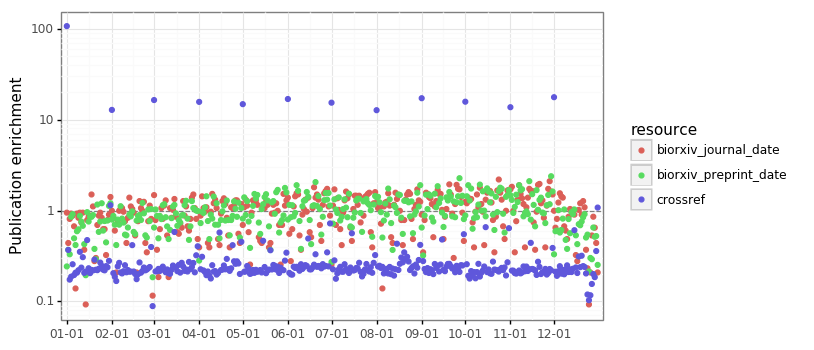

<ggplot: (8754630279677)>

In [11]:
plotnine.options.figure_size = (7, 4)
gg = (
    plotnine.ggplot(
        mapping=plotnine.aes(x='month_day_rank', y='enrichment', color='resource'),
        data=month_day_count_df,
    ) +
    plotnine.geom_hline(yintercept=1, color='grey', linetype='dashed') +
    plotnine.scale_x_continuous(
        breaks=list(month_day_rank_breaks),
        labels=list(month_day_rank_breaks.values()),
        name='',
        expand=(0, 4),
    ) +
    plotnine.scale_y_log10(
        name='Publication enrichment',
        labels=lambda array: [f'{x:.1g}' if x < 1 else f'{x:.0f}' for x in array],
    ) +
    plotnine.geom_point() +
    plotnine.theme_bw()
)
gg

In [13]:
plotnine.ggsave(gg, filename='figures/51.publication-month-day-distribution.png', dpi=300)
plotnine.ggsave(gg, filename='figures/51.publication-month-day-distribution.svg')

/home/dhimmel/anaconda3/envs/greenblack/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 7 x 4 in image.
  from_inches(height, units), units))
/home/dhimmel/anaconda3/envs/greenblack/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/51.publication-month-day-distribution.png
  warn('Filename: {}'.format(filename))
/home/dhimmel/anaconda3/envs/greenblack/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 7 x 4 in image.
  from_inches(height, units), units))
/home/dhimmel/anaconda3/envs/greenblack/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/51.publication-month-day-distribution.svg
  warn('Filename: {}'.format(filename))
